# 롱-숏 전략, 3부: 부스팅 모델 시그널의 평가

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. `evaluate_trading_signals` (this noteboook): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Cross-validation of numerous configurations has produced a large number of results. Now, we need to evaluate the predictive performance to identify the model that generates the most reliable and profitable signals for our prospective trading strategy.

## Imports & Settings

In [2]:
!pip install --upgrade alphalens-reloaded tables

     |████████████████████████████████| 51 kB 302 kB/s 
     |████████████████████████████████| 4.3 MB 9.7 MB/s 
     |████████████████████████████████| 6.3 MB 57.7 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from pathlib import Path
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from scipy.stats import spearmanr, pearsonr

from alphalens import plotting
from alphalens import performance as perf
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return, std_conversion
from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

In [5]:
os.chdir('/content/drive/MyDrive/금융특화 AI 역량강화교육 - 증권 (심화) -/12_gradient_boosting_machines')

In [6]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [7]:
sns.set_style('whitegrid')

In [8]:
YEAR = 252
idx = pd.IndexSlice

In [9]:
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
catboost_train_params = ['max_depth', 'min_child_samples']

In [10]:
results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## 데이터 수집

LightGBM이 CatBoost보다 훨씬 빠르게 실행되기 때문에 더 많은 전략 평가를 시연할 수 있도록 더 많은 수의 LightGBM 모델을 실행한다.

### LightGBM

#### 폴드별 요약 척도

첫째, 각 폴드와 하이퍼파라미터 조합에 대해 계산된 요약 척도를 수지한다.

In [11]:
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead': t,
            'train_length': train_length,
            'test_length': test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = pd.melt(lgb_metrics.T.drop('t', axis=1), 
                  id_vars=id_vars, 
                  value_name='ic', 
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [12]:
lgb_metrics.to_hdf('data/model_tuning.h5', 'lgb/metrics')
lgb_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 103
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          84 non-null     int64  
 1   train_length       84 non-null     int64  
 2   test_length        84 non-null     int64  
 3   learning_rate      84 non-null     float64
 4   num_leaves         84 non-null     float64
 5   feature_fraction   84 non-null     float64
 6   min_data_in_leaf   84 non-null     float64
 7   daily_ic_mean      84 non-null     float64
 8   daily_ic_mean_n    84 non-null     float64
 9   daily_ic_median    84 non-null     float64
 10  daily_ic_median_n  84 non-null     float64
 11  boost_rounds       84 non-null     int64  
 12  ic                 84 non-null     float64
dtypes: float64(9), int64(4)
memory usage: 9.2 KB


In [13]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          252           63             84
dtype: int64

#### 일별 IC

다음, CV에서 계산한 일별 IC를 추출한다.

In [14]:
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

In [15]:
lgb_ic = []
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                  .drop(['boosting', 'objective', 'verbose'], axis=1)
                 .assign(lookahead=t, 
                         train_length=train_length, 
                         test_length=test_length))
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()

In [16]:
id_vars = ['date'] + scope_params + lgb_train_params
lgb_ic = pd.melt(lgb_ic, 
                 id_vars=id_vars, 
                 value_name='ic', 
                 var_name='boost_rounds').dropna()
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)

In [18]:
lgb_ic.to_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42335 entries, 0 to 52415
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              42335 non-null  datetime64[ns]
 1   lookahead         42335 non-null  int64         
 2   train_length      42335 non-null  int64         
 3   test_length       42335 non-null  int64         
 4   learning_rate     42335 non-null  float64       
 5   num_leaves        42335 non-null  int64         
 6   feature_fraction  42335 non-null  float64       
 7   min_data_in_leaf  42335 non-null  int64         
 8   boost_rounds      42335 non-null  int64         
 9   ic                42335 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 3.6 MB


In [17]:
lgb_daily_ic = lgb_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
lgb_daily_ic.to_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         84 non-null     int64  
 1   train_length      84 non-null     int64  
 2   test_length       84 non-null     int64  
 3   learning_rate     84 non-null     float64
 4   num_leaves        84 non-null     int64  
 5   feature_fraction  84 non-null     float64
 6   min_data_in_leaf  84 non-null     int64  
 7   boost_rounds      84 non-null     int64  
 8   ic                84 non-null     float64
dtypes: float64(3), int64(6)
memory usage: 6.0 KB


In [19]:
lgb_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')

### CatBoost

유사하게 Catboot에 대해 실행한다.

#### 요약 척도

In [43]:
with pd.HDFStore(results_path / 'tuning_catboost.h5') as store:
    for i, key in enumerate(
            [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead'   : t,
            'train_length': train_length,
            'test_length' : test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            catboost_metrics = pd.Series(s).to_frame(i)
        else:
            catboost_metrics[i] = pd.Series(s)

id_vars = scope_params + catboost_train_params + daily_ic_metrics
catboost_metrics = pd.melt(catboost_metrics.T.drop('t', axis=1),
                           id_vars=id_vars,
                           value_name='ic',
                           var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [44]:
catboost_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 2
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          3 non-null      int64  
 1   train_length       3 non-null      int64  
 2   test_length        3 non-null      int64  
 3   max_depth          3 non-null      float64
 4   min_child_samples  3 non-null      float64
 5   daily_ic_mean      3 non-null      float64
 6   daily_ic_mean_n    3 non-null      float64
 7   daily_ic_median    3 non-null      float64
 8   daily_ic_median_n  3 non-null      float64
 9   boost_rounds       3 non-null      int64  
 10  ic                 3 non-null      float64
dtypes: float64(7), int64(4)
memory usage: 288.0 bytes


In [45]:
catboost_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          252           63             3
dtype: int64

#### 일별 IC

In [46]:
catboost_ic = []
with pd.HDFStore(results_path / 'tuning_catboost.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                  # .drop('task_type', axis=1)
                 .assign(lookahead=t,
                         train_length=train_length,
                         test_length=test_length))
            catboost_ic.append(df)
    catboost_ic = pd.concat(catboost_ic).reset_index()

In [47]:
id_vars = ['date'] + scope_params + catboost_train_params
catboost_ic = pd.melt(catboost_ic, 
                      id_vars=id_vars, 
                      value_name='ic', 
                      var_name='boost_rounds').dropna()
catboost_ic.loc[:, int_cols] = catboost_ic.loc[:, int_cols].astype(int)

In [48]:
catboost_ic.to_hdf('data/model_tuning.h5', 'catboost/ic')
catboost_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1512 entries, 0 to 1511
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1512 non-null   datetime64[ns]
 1   lookahead          1512 non-null   int64         
 2   train_length       1512 non-null   int64         
 3   test_length        1512 non-null   int64         
 4   max_depth          1512 non-null   int64         
 5   min_child_samples  1512 non-null   int64         
 6   boost_rounds       1512 non-null   int64         
 7   ic                 1512 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 106.3 KB


In [49]:
catboost_daily_ic = catboost_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
catboost_daily_ic.to_hdf('data/model_tuning.h5', 'catboost/daily_ic')
catboost_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          3 non-null      int64  
 1   train_length       3 non-null      int64  
 2   test_length        3 non-null      int64  
 3   max_depth          3 non-null      int64  
 4   min_child_samples  3 non-null      int64  
 5   boost_rounds       3 non-null      int64  
 6   ic                 3 non-null      float64
dtypes: float64(1), int64(6)
memory usage: 296.0 bytes


In [50]:
catboost_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/ic')
catboost_daily_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/daily_ic')

## 검증 성과: 일별 대 전체 IC

다음 이미지는 LightGBM(주황색)이 특히 긴 기간에서 CatBoost보다 (약간) 더 잘 수행됨을 보여준다. 이는 LightGBM에 대해 더 많은 설정을 실행했기 때문에 완전히 공정한 비교는 아니다. 이는 놀랄 것도 없이 결과의 광범위한 분포를 보여준다.


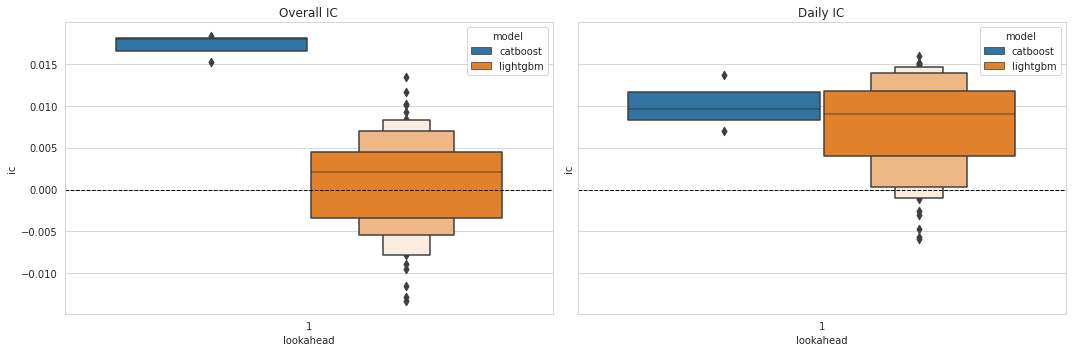

In [ ]:
#@title
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=catboost_metrics.assign(model='catboost')
              .append(lgb_metrics.assign(model='lightgbm')), ax=axes[0])
axes[0].axhline(0, ls='--', lw=1, c='k')
axes[0].set_title('Overall IC')
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=catboost_daily_ic.assign(model='catboost')
              .append(lgb_daily_ic.assign(model='lightgbm')), ax=axes[1])
axes[1].axhline(0, ls='--', lw=1, c='k')
axes[1].set_title('Daily IC')
fig.tight_layout()

## 하이퍼파라미터 여향: 선형회귀

다음으로, 하이퍼파라미터와 일일 예측에 걸친 결과 사이에 체계적이고 통계적인 관계가 있는지 알고자 한다. 이를 위해 다양한 LightGBM 하이퍼 파라미터 설정을 더미 변수(특성)로 사용하고 일일 검증 IC를 결과(타겟)로 사용해 선형 회귀 분석을 실행한다.

다음 차트는 1일 및 21일 예측기간에 대한 계수 추정치와 신뢰 구간을 보여준다. 
- 예측기간이 짧을수록 긴 룩백기간, 높은 학습률, 깊은 트리(더 많은 리프 노드 수)가 양의 영향을 갖는다. 
- 예측기간이 길수록 결과는 조금 덜 명확하다. 얕은 트리가 낫지만 룩백기간은 그리 유의하지 않다. 특성 샘플링율이 클수록 도움이 된다. 두 경우 모두 더 큰 앙상블이 더 낫다. 

이러한 결과는 이 특정 예에만 적용된다는 것을 주의하라.

In [51]:
lin_reg = {}
# for t in [1, 21]:
for t in [1]:
    df_ = lgb_ic[lgb_ic.lookahead==t]
    y, X = df_.ic, df_.drop(['ic'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err', 't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(f'results/linreg_result_{t:02}.csv', index=False)

In [52]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith('date')&(coefs.variable!='const')]

    coefs.plot(x='variable', y='coef', kind='bar', 
                 ax=ax, color='none', capsize=3,
                 yerr='error', legend=False)
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

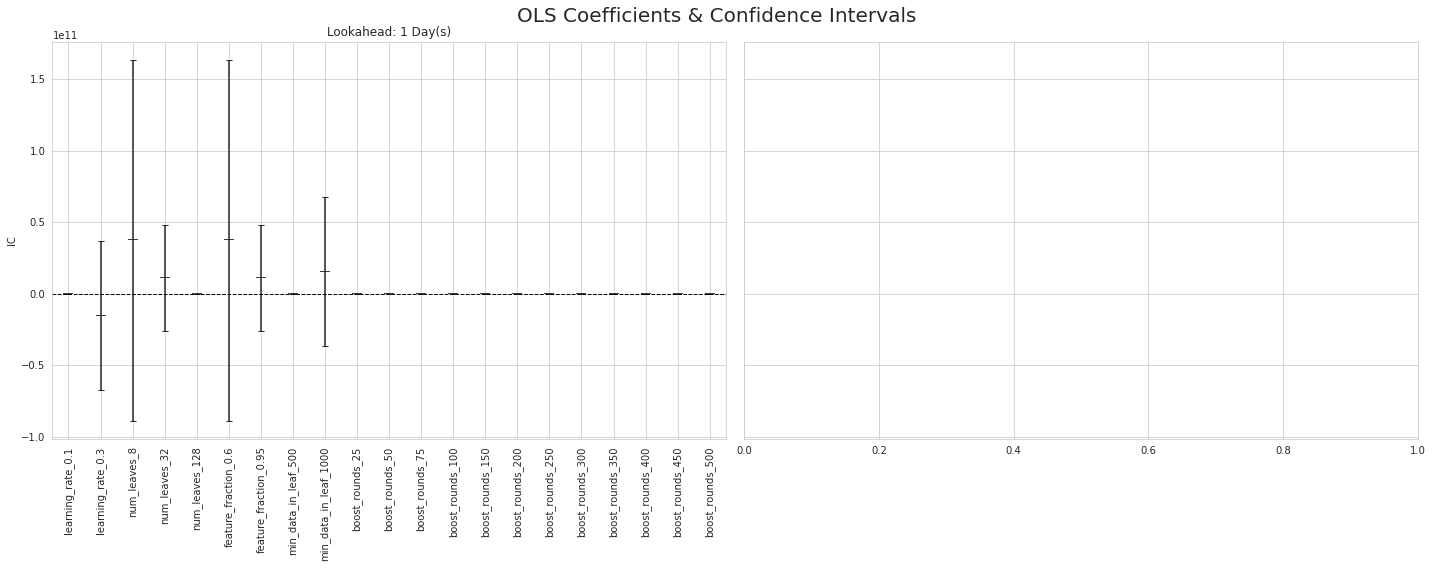

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
axes = axes.flatten()
# for i, t in enumerate([1, 21]):
for i, t in enumerate([1]):
    visualize_lr_result(lin_reg[t], axes[i])
    axes[i].set_title(f'Lookahead: {t} Day(s)')
fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.92);

## 교차검증 결과: 최적 하이퍼파라미터

### LightGBM

최고 성과의 LightGBM 모델은 세 가지 다른 예측 기간에 대해 다음 파라미터를 사용한다.

In [ ]:
group_cols = scope_params + lgb_train_params + ['boost_rounds']
lgb_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
44,1,252,63,0.1,32,0.95,1000,500,0.015902
40,1,252,63,0.1,32,0.95,1000,300,0.015107
43,1,252,63,0.1,32,0.95,1000,450,0.015038


In [ ]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_lgb_model.csv', index=False)

In [ ]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
3,1,252,63,0.1,32.0,0.95,1000.0,0.015902,500.0,0.014478,500.0,10,0.006721
11,1,252,63,0.1,32.0,0.95,1000.0,0.015902,500.0,0.014478,500.0,25,0.002970
19,1,252,63,0.1,32.0,0.95,1000.0,0.015902,500.0,0.014478,500.0,50,0.001689


### CatBoost

In [54]:
group_cols = scope_params + catboost_train_params + ['boost_rounds']
catboost_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,lookahead,train_length,test_length,max_depth,min_child_samples,boost_rounds,ic
1,1,252,63,3,20,25,0.013931
2,1,252,63,3,20,50,0.012747
0,1,252,63,3,20,10,0.012709


In [55]:
catboost_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,lookahead,train_length,test_length,max_depth,min_child_samples,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
0,1,252,63,3.0,20.0,0.013931,25.0,0.014877,25.0,10,0.016463
1,1,252,63,3.0,20.0,0.013931,25.0,0.014877,25.0,25,0.016203
2,1,252,63,3.0,20.0,0.013931,25.0,0.014877,25.0,50,0.011533


In [56]:
catboost_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

,lookahead,train_length,test_length,max_depth,min_child_samples,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
0,1,252,63,3.0,20.0,0.013931,25.0,0.014877,25.0,10,0.016463
1,1,252,63,3.0,20.0,0.013931,25.0,0.014877,25.0,25,0.016203
2,1,252,63,3.0,20.0,0.013931,25.0,0.014877,25.0,50,0.011533


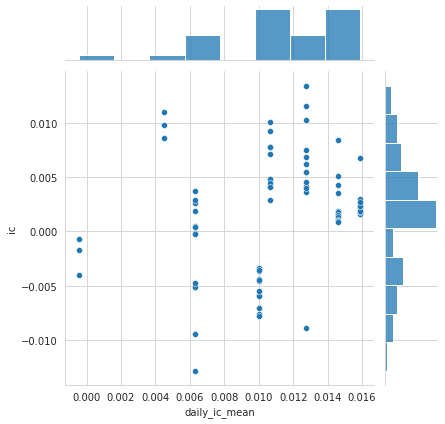

In [57]:
sns.jointplot(x=lgb_metrics.daily_ic_mean,y=lgb_metrics.ic);

### 시각화

#### LightGBM

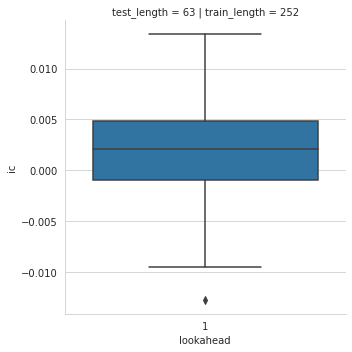

In [58]:
g = sns.catplot(x='lookahead', y='ic',
                col='train_length', row='test_length',
                data=lgb_metrics,
                kind='box')

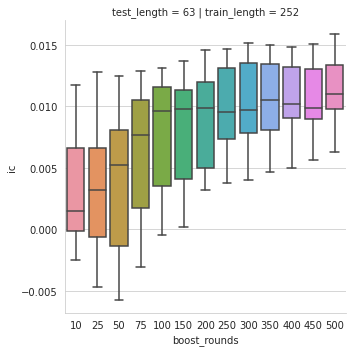

In [59]:
t=1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=lgb_daily_ic[lgb_daily_ic.lookahead == t],
            kind='box')

#### CatBoost

모든 파라미터 조합을 실행하지 않았기 때문에 일부 수치가 비어 있다.

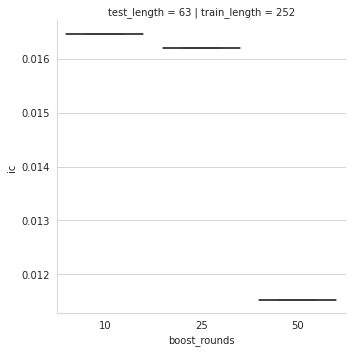

In [60]:
t = 1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=catboost_metrics[catboost_metrics.lookahead == t],
            kind='box')

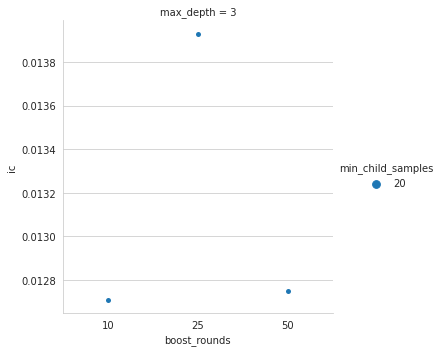

In [61]:
t = 1
train_length = 252
test_length = 63
g = sns.catplot(
    x='boost_rounds',
    y='ic',
    col='max_depth',
    hue='min_child_samples',
    data=catboost_daily_ic[(catboost_daily_ic.lookahead == t) &
                      (catboost_daily_ic.train_length == train_length) &
                      (catboost_daily_ic.test_length == test_length)],
    kind='swarm')

## 알파렌드(AlphaLens) 분석 - 검증 성과

### LightGBM

#### 파라미터 선택

In [20]:
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         84 non-null     int64  
 1   train_length      84 non-null     int64  
 2   test_length       84 non-null     int64  
 3   learning_rate     84 non-null     float64
 4   num_leaves        84 non-null     int64  
 5   feature_fraction  84 non-null     float64
 6   min_data_in_leaf  84 non-null     int64  
 7   boost_rounds      84 non-null     int64  
 8   ic                84 non-null     float64
dtypes: float64(3), int64(6)
memory usage: 6.6 KB


In [21]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [22]:
def get_lgb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/'
    return key + f'{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}'

In [23]:
best_params = get_lgb_params(lgb_daily_ic, t=1, best=0)
best_params

train_length         252.00
test_length           63.00
learning_rate          0.10
num_leaves            32.00
feature_fraction       0.95
min_data_in_leaf    1000.00
boost_rounds         500.00
Name: 44, dtype: float64

In [24]:
best_params.to_hdf('data.h5', 'best_params')

#### 롤링 IC 그래프

In [25]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.learning_rate == params.learning_rate) &
                       (ic_data.num_leaves == params.num_leaves) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

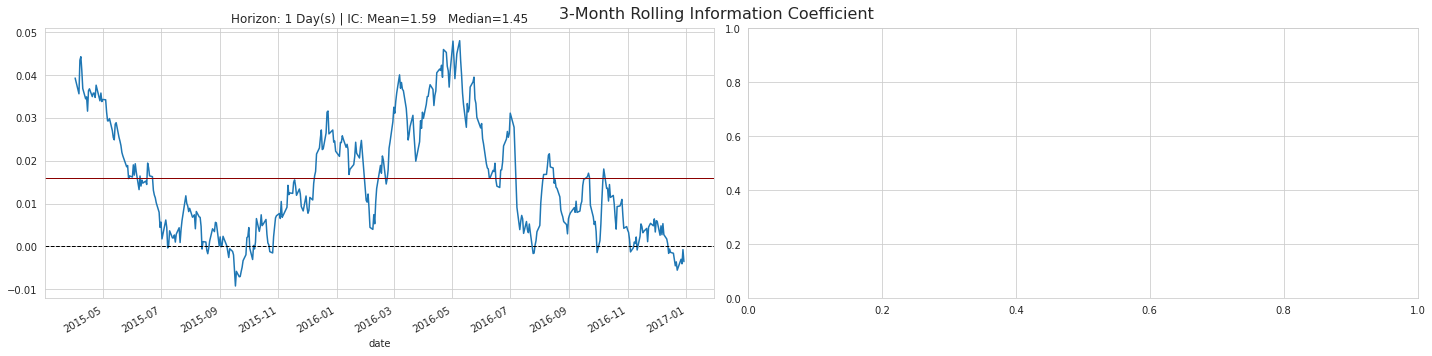

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
# for i, t in enumerate([1, 21]):
for i, t in enumerate([1]):
    params = get_lgb_params(lgb_daily_ic, t=t)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

#### 검증 기간에 대한 예측 

10 검증 실행에 대한 예측을 추출한다.

In [27]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_daily_ic, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_lgb.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_lgb.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [28]:
best_predictions.to_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 500317 entries, ('A', Timestamp('2015-01-02 00:00:00')) to ('UDR', Timestamp('2016-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       500317 non-null  float64
 1   1       500317 non-null  float64
 2   2       500317 non-null  float64
 3   3       500317 non-null  float64
 4   4       500317 non-null  float64
 5   5       500317 non-null  float64
 6   6       500317 non-null  float64
 7   7       500317 non-null  float64
 8   8       500317 non-null  float64
 9   9       500317 non-null  float64
dtypes: float64(10)
memory usage: 40.1+ MB


#### 거래 가격을 얻는다.

다음 사용가능한 가격을 얻는다

In [29]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = '../data/assets.h5'
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2015': '2017'], 'adj_open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [30]:
test_tickers = best_predictions.index.get_level_values('symbol').unique()

In [31]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 993 entries, A to UDR
dtypes: float64(993)
memory usage: 5.7 MB


In [32]:
# 다시 실행하는 경우 결과를 저장한다.
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

우리는 다양한 보유 기간에 대해 5분위 일일 팩터에 투자된 동일비중 포트폴리오에서 얻은 평균 기간별 수익률을 계산하기 위해 상위 5개 모델의 평균을 내고, 관련 가격을 알파렌즈에 제공한다.

In [33]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

#### 알파렌즈 입력을 생성한다. 

In [34]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


#### 알파렌즈 척도를 계산한다. 

In [35]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [36]:
factor_returns = perf.factor_returns(factor_data)

In [37]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)



mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

In [38]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [39]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

,1D,5D,10D,21D
Mean Period Wise Spread (bps),8.812720,2.929922,2.950314,2.582974
Ann. alpha,0.121897,0.032921,0.022728,0.012936
beta,0.049779,0.073503,0.132926,0.156871


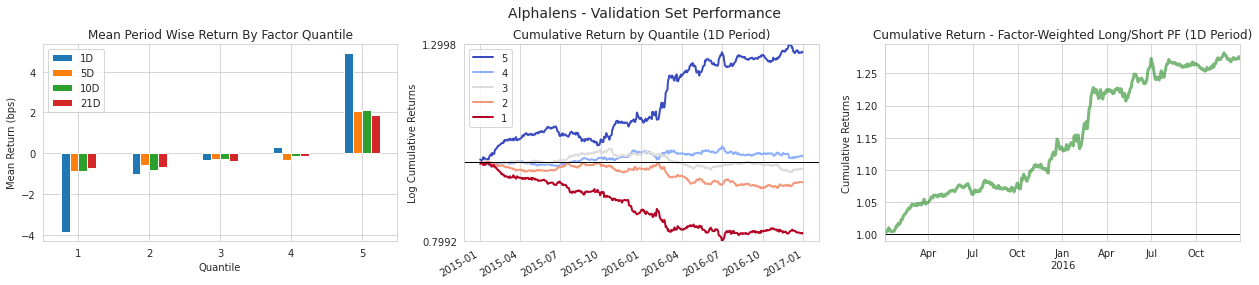

In [40]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

#### 요약 테어시트(Summary Tearsheet)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.061663,0.019780,-0.004549,0.007045,100295,20.046291
2,-0.020917,0.023109,-0.001336,0.006579,99792,19.945754
3,-0.018208,0.025790,0.000307,0.006708,100183,20.023905
4,-0.015025,0.029222,0.001926,0.006893,99792,19.945754
5,-0.011561,0.043756,0.005199,0.007798,100255,20.038296


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.122,0.033,0.023,0.013
beta,0.050,0.074,0.133,0.157
Mean Period Wise Return Top Quantile (bps),4.929,2.077,2.103,1.876
Mean Period Wise Return Bottom Quantile (bps),-3.884,-0.871,-0.874,-0.735
Mean Period Wise Spread (bps),8.813,2.930,2.950,2.583


Information Analysis


,1D,5D,10D,21D
IC Mean,0.014,0.008,0.014,0.018
IC Std.,0.114,0.122,0.128,0.122
Risk-Adjusted IC,0.123,0.066,0.106,0.145
t-stat(IC),2.762,1.490,2.387,3.247
p-value(IC),0.006,0.137,0.017,0.001
IC Skew,-0.072,-0.104,-0.003,0.165
IC Kurtosis,0.928,2.421,1.203,0.873


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.614,0.660,0.713,0.770
Quantile 2 Mean Turnover,0.749,0.761,0.778,0.790
Quantile 3 Mean Turnover,0.766,0.774,0.781,0.788
Quantile 4 Mean Turnover,0.752,0.760,0.780,0.794
Quantile 5 Mean Turnover,0.602,0.655,0.707,0.766


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.351,0.264,0.158,0.034


<Figure size 432x288 with 0 Axes>

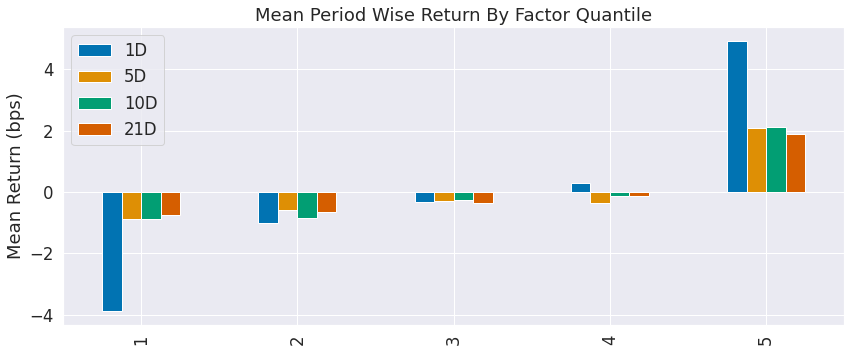

In [41]:
create_summary_tear_sheet(factor_data)

In [42]:
create_full_tear_sheet(factor_data)

Output hidden; open in https://colab.research.google.com to view.

### CatBoost

#### 파라미터 선택

In [62]:
catboost_daily_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/daily_ic')
catboost_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 2
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          3 non-null      int64  
 1   train_length       3 non-null      int64  
 2   test_length        3 non-null      int64  
 3   max_depth          3 non-null      int64  
 4   min_child_samples  3 non-null      int64  
 5   boost_rounds       3 non-null      int64  
 6   ic                 3 non-null      float64
dtypes: float64(1), int64(6)
memory usage: 192.0 bytes


In [63]:
catboost_daily_ic

,lookahead,train_length,test_length,max_depth,min_child_samples,boost_rounds,ic
0,1,252,63,3,20,10,0.012709
1,1,252,63,3,20,25,0.013931
2,1,252,63,3,20,50,0.012747


In [64]:
def get_cb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + catboost_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [65]:
def get_cb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/'
    return key + f'{int(p.max_depth)}/{int(p.min_child_samples)}'

In [66]:
best_params = get_cb_params(catboost_daily_ic, t=1, best=0)
best_params

train_length         252.0
test_length           63.0
max_depth              3.0
min_child_samples     20.0
boost_rounds          25.0
Name: 1, dtype: float64

In [67]:
def select_cb_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.max_depth == params.max_depth) &
                       (ic_data.min_child_samples == params.min_child_samples)].set_index('date')

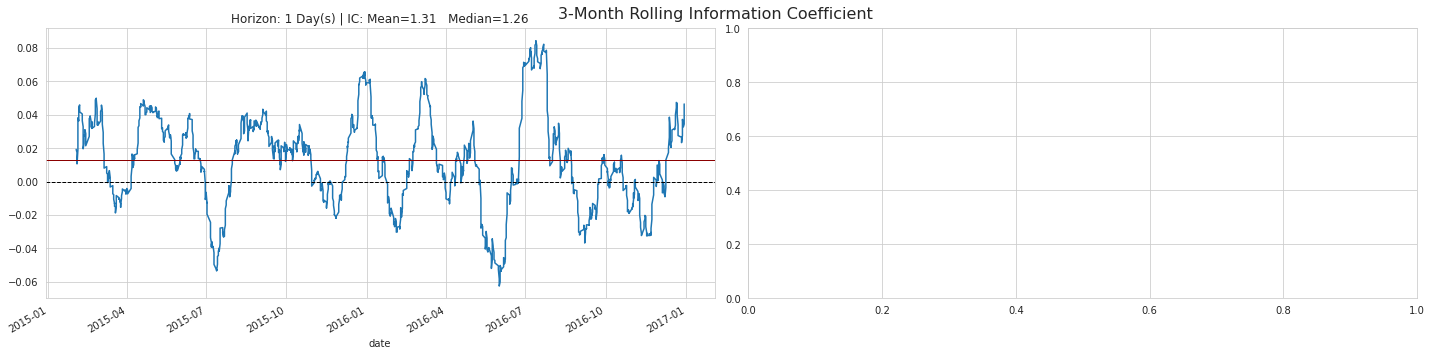

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
# for i, t in enumerate([1, 21]):
for i, t in enumerate([1]):
    params = get_cb_params(catboost_daily_ic, t=t)
    data = select_cb_ic(params, catboost_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

#### 예측을 얻는다.

In [69]:
with pd.HDFStore(results_path / 'tuning_catboost.h5') as store:
  print(store.keys())

['/predictions/1/252/63', '/metrics/1/252/63', '/daily_ic/1/252/63']


In [70]:
lookahead = 1
topn = 1
for best in range(topn):
    best_params = get_cb_params(catboost_daily_ic, t=lookahead, best=best)
    key = get_cb_key(lookahead, best_params)
    # 파일 못읽는 문제 해결으리 위해 실행
    key = "1/252/63"
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_catboost.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_catboost.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [71]:
best_predictions.to_hdf('data/predictions.h5', f'catboost/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 500317 entries, ('A', Timestamp('2015-01-02 00:00:00')) to ('UDR', Timestamp('2016-12-30 00:00:00'))
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       500317 non-null  float64
dtypes: float64(1)
memory usage: 5.8+ MB


#### 거래 가격을 얻는다.

다음 거래가능 가격을 얻는다.

In [72]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = '../data/assets.h5'
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2015': '2017'], 'adj_open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [73]:
test_tickers = best_predictions.index.get_level_values('symbol').unique()

In [74]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 993 entries, A to UDR
dtypes: float64(993)
memory usage: 5.7 MB


In [75]:
# 시간을 절약하기 위해 한번만 생성한다. 
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [76]:
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [77]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

#### 알파렌즈 입력을 생성한다. 

In [78]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))

Dropped 16.1% entries from factor data: 0.0% in forward returns computation and 16.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


#### 요약 테어시트(Summary Tearsheet)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.020161,0.006940,-0.000333,0.003274,98612,23.485143
2.0,-0.008787,0.007425,0.000027,0.003171,82415,19.627713
3.0,-0.008225,0.008148,0.000228,0.003216,87451,20.827072
4.0,-0.007746,0.008609,0.000311,0.003360,81914,19.508396
5.0,-0.006958,0.022008,0.001108,0.003430,69499,16.551677


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.073,0.020,0.013,0.015
beta,0.063,0.070,0.109,0.091
Mean Period Wise Return Top Quantile (bps),5.315,1.125,1.497,0.805
Mean Period Wise Return Bottom Quantile (bps),-2.593,-0.421,-0.616,-0.692
Mean Period Wise Spread (bps),7.908,1.494,2.052,1.443


Information Analysis


,1D,5D,10D,21D
IC Mean,0.011,0.008,0.018,0.018
IC Std.,0.123,0.130,0.135,0.124
Risk-Adjusted IC,0.086,0.058,0.132,0.144
t-stat(IC),NaN,NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN,NaN
IC Skew,NaN,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN,NaN


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.588,0.613,0.687,0.741
Quantile 2 Mean Turnover,0.738,0.751,0.786,0.792
Quantile 3 Mean Turnover,0.725,0.746,0.768,0.781
Quantile 4 Mean Turnover,0.716,0.729,0.776,0.792
Quantile 5 Mean Turnover,0.614,0.653,0.735,0.800


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.303,0.297,0.143,0.034


<Figure size 432x288 with 0 Axes>

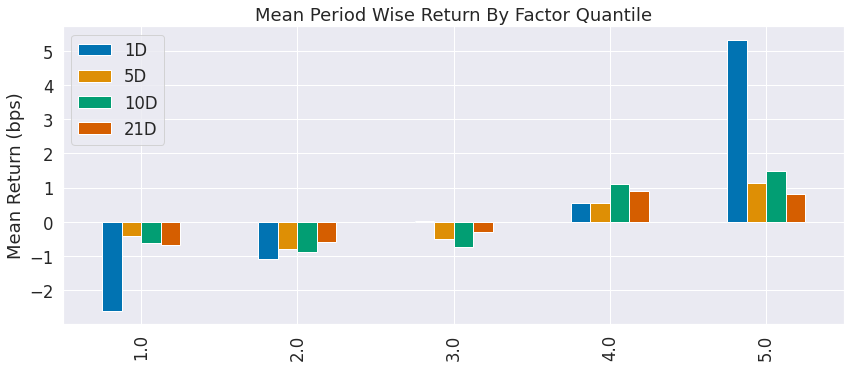

In [79]:
create_summary_tear_sheet(factor_data)

In [80]:
create_full_tear_sheet(factor_data)

Output hidden; open in https://colab.research.google.com to view.